# level of analysis : single channel 
### in this notebook I compute TF difference between 3 conditions and the significance clusters based on permutation cluster test. I do analysis for only channels with dignificance decoding value and only few electrodes to test 

In [ ]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit

base_eid_path = '/mnt/data/AdaptiveControl/IBLrawdata/eid_data'
base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data = pd.read_csv(path_summary_data)


def load_tfr(pid, ch_name, version ):
    """
    Load time-frequency representation (TFR) data using MNE.

    Parameters:
    pid (str): Participant ID.
    ch_name (str): Channel name.

    Returns:
    epochTFR (mne.time_frequency.EpochsTFR or None): The loaded TFR data. Returns None if the file is not found.
    """
    tfr_path = os.path.join(base_TF_path, pid, f'powerLF_{version}_{ch_name}.h5')
    if os.path.isfile(tfr_path):
        epochTFR = mne.time_frequency.read_tfrs(tfr_path)
        return epochTFR
    else:
        print(f'TFR file not found for {pid} - {ch_name}')
        return None


def compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial):
    """
    Compute the difference in average TFR between two conditions.

    Parameters:
    epochTFR (mne.time_frequency.EpochsTFR): The TFR data.
    condition1_trial (list of int): Indices of trials for condition 1.
    condition2_trial (list of int): Indices of trials for condition 2.

    Returns:
    diff_data (numpy.ndarray): The difference in average TFR between the two conditions.
    c1_data (numpy.ndarray): The log-transformed TFR data for condition 1.
    c2_data (numpy.ndarray): The log-transformed TFR data for condition 2.
    """
    c1_data = np.log10(epochTFR.data[condition1_trial].squeeze())
    c2_data = np.log10(epochTFR.data[condition2_trial].squeeze())
    c1_data_av = np.mean(c1_data, axis=0)
    c2_data_av = np.mean(c2_data, axis=0)
    diff_data = c1_data_av - c2_data_av
    return diff_data, c1_data, c2_data


def diff_TF_permute(row, n_permutations=500, threshold=None, version = 'raw'):
    """
    Process a row of summary data to compute the difference in TFR between conditions and perform permutation tests.

    Parameters:
    row (pandas.Series): A row of the summary data.
    n_permutations (int, optional): The number of permutations to perform in the permutation test. Default is 500.
    threshold (float, optional): The threshold for the cluster test. Default is None.
    version (str, optional): The version of the TFR data to load. Default is 'raw'.

    Returns:
    None
    """
    
    eid = row['eid']
    pid = row['pid']
    
    path_epoch_quality = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/epoch_quality_{version}.csv'

    quality_data = pd.read_csv(path_epoch_quality)

    bad_trials = quality_data[(quality_data['skewness'] > 1.5) | (quality_data['max_power'] > 500) ]['epoch'].values
    bad_trials = list(set(bad_trials))
    for condition, signif_channel_col in {
        'Stim_NoStim': 'signif_channel_StimNoStim',
        'Right_Left': 'signif_channel_RightLeft',
        'BiasRight_BiasLeft': 'signif_channel_BiasLeftBiasRight'
    }.items():
        signif_channels = row[signif_channel_col]
        if pd.isna(signif_channels) or not signif_channels:
            continue
        print(f' type signif_channels {type(signif_channels)}')
        if isinstance(signif_channels, str):
            signif_channels = eval(signif_channels)
        print(f' type signif_channels {type(signif_channels)}')
        for item in signif_channels:
            # Ensure each item is a pair (ch_name, acc_value)
            if not isinstance(item, (list, tuple)) or len(item) != 2:
                print(f'Unexpected item format: {item} in {pid} - {condition}')
                return
            
            ch_name, acc_value = item
            
            print(f' {ch_name} - acc = {acc_value}')
            
            epochTFR = load_tfr(pid, ch_name, version = version)
            if epochTFR is None:
                continue
            
            meta = epochTFR.metadata.reset_index()

            
            if condition == 'Stim_NoStim':
                condition1_trial = meta.index[(meta['contrastLeft'] == 1) | (meta['contrastRight'] == 1)].tolist()
                condition2_trial = meta.index[(meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1)].tolist()
            elif condition == 'Right_Left':
                condition1_trial = meta.index[meta['contrastRight'] == 1].tolist()
                condition2_trial = meta.index[meta['contrastLeft'] == 1].tolist()
            elif condition == 'BiasRight_BiasLeft':
                condition1_trial = meta.index[meta['probabilityLeft'] == 0.2].tolist()
                condition2_trial = meta.index[meta['probabilityLeft'] == 0.8].tolist()
            else:
                continue
            
            # Exclude noisy trials
            condition1_trial = [trial for trial in condition1_trial if trial not in bad_trials]
            condition2_trial = [trial for trial in condition2_trial if trial not in bad_trials]
            number_of_trials = len(condition1_trial), len(condition2_trial)
            diff_data, c1_data, c2_data = compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial)
            print(f'Computed difference in average TFR for {pid} - {ch_name} - {condition}')
            print(f'Running permutation test for {pid} - {ch_name} - {condition}')
            F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([c1_data, c2_data], out_type='mask', n_permutations=n_permutations, threshold=threshold, tail=0, n_jobs=5)
            print(f'Permutation test completed for {pid} - {ch_name} - {condition}')
            save_path = os.path.join(base_TF_path, pid, f'TFRpermut_LF_{condition}_{ch_name}_{version}.h5')
            with h5py.File(save_path, 'w') as hf:
                hf.create_dataset('diff_data', data=diff_data)
                hf.create_dataset('F_obs', data=F_obs)
                hf.create_dataset('clusters', data=np.array([c.astype(int) for c in clusters]))
                hf.create_dataset('cluster_p_values', data=cluster_p_values)
                hf.create_dataset('H0', data=H0)
                hf.create_dataset('condition', data=np.string_(condition))  
                hf.create_dataset('acc_value', data=acc_value)  
                hf.create_dataset('eid', data=eid)
                hf.create_dataset('pid', data=pid)
                hf.create_dataset('ch_name', data=np.string_(ch_name))
                hf.create_dataset('n_permutations', data=n_permutations)
                hf.create_dataset('threshold', data=threshold if threshold is not None else np.nan)
                hf.create_dataset('number_of_trials', data=number_of_trials)
                hf.create_dataset('version', data=np.string_(version))
                hf.create_dataset('times', data=epochTFR.times)
                hf.create_dataset('freqs', data=epochTFR.freqs)
                
                
            print(f'Saved permutation results for {pid} - {ch_name} - {condition}')
        
            
        




In [ ]:
# test the function
summary_data_short = summary_data[11:12]
executor = submitit.AutoExecutor(folder="permute_logs")

# Define maxjobs to a low value to illustrate
maxjobs = 10000

# Pass parameter to the executor
executor.update_parameters(slurm_array_parallelism=maxjobs, mem_gb=25, timeout_min=600, slurm_partition="CPU", cpus_per_task=6)


# Execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.map_array(diff_TF_permute, [row for _, row in summary_data_short.iterrows()])

print("Jobs submitted")

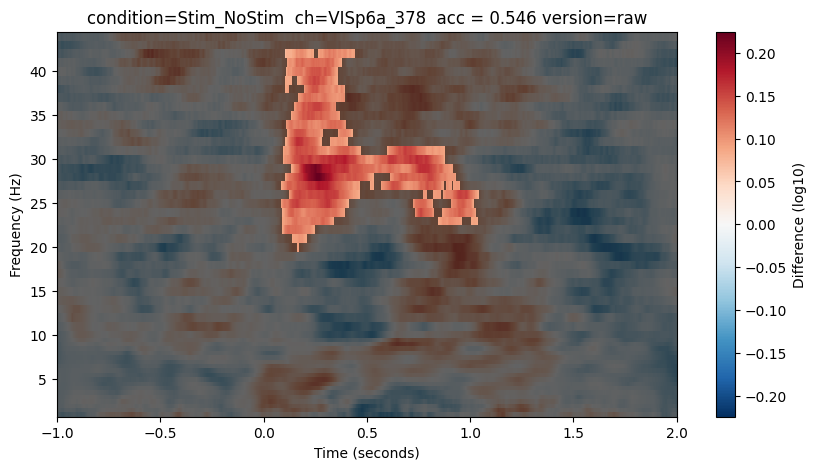

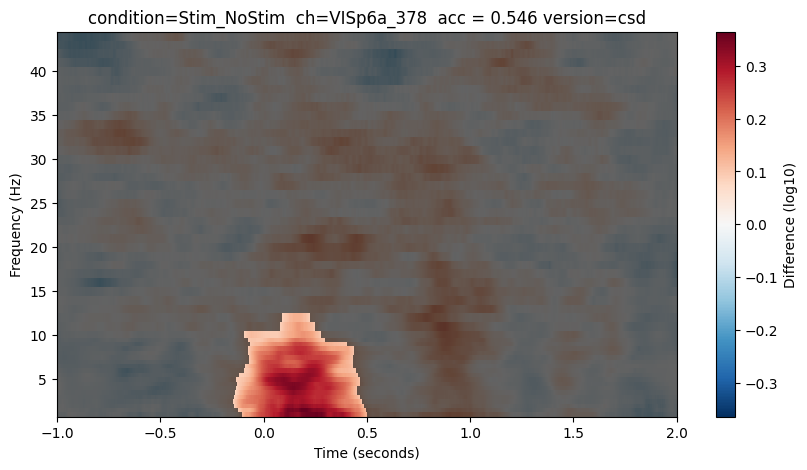

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_h5_file(file_path):
    """
    Load data from an HDF5 file and print the datasets.

    Parameters:
    file_path (str): The path to the HDF5 file.

    Returns:
    dict: A dictionary containing the datasets.
    """
    data = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            if hf[key].shape == ():  # Check if the dataset is a scalar
                value = hf[key][()]
                if isinstance(value, bytes):  # Check if the value is a byte string
                    value = value.decode('utf-8')
                data[key] = value
            else:
                data[key] = hf[key][:]
                if isinstance(data[key], np.ndarray) and data[key].dtype.type is np.bytes_:
                    data[key] = data[key].astype(str)
            
    return data

version_list = ['raw','csd']
for f in version_list:
    file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/a6fe3779-2b77-4b66-a625-a6078720e412/TFRpermut_LF_Stim_NoStim_VISp6a_378_{f}.h5'
    data = load_h5_file(file_path)

    diff_data= data['diff_data']
    clusters= [data['clusters'][i] for i in range(len(data['clusters']))]
    cluster_p_values = data['cluster_p_values']
    timearray = data['times']
    freqarray = data['freqs']
    condition = data['condition']
    channel = data['ch_name']
    version = data['version']
    acc = data['acc_value']
    acc = round(acc, 3)
    # Create a mask of significant clusters
    significant_mask = np.zeros_like(diff_data, dtype=bool)
    for i, cluster in enumerate(clusters):
        if cluster_p_values[i] < 0.05:
            significant_mask |= cluster.astype(bool)

            
    # Calculate time and frequency edges
    time_edges = np.concatenate(([timearray[0] - (timearray[1] - timearray[0]) / 2],
                                    (timearray[:-1] + timearray[1:]) / 2,
                                    [timearray[-1] + (timearray[-1] - timearray[-2]) / 2]))
    freq_edges = np.concatenate(([freqarray[0] - (freqarray[1] - freqarray[0]) / 2],
                                    (freqarray[:-1] + freqarray[1:]) / 2,
                                    [freqarray[-1] + (freqarray[-1] - freqarray[-2]) / 2]))

    # Plot the difference
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                    vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
    plt.colorbar(label='Difference (log10)')
    plt.title(f'condition={condition}  ch={channel}  acc = {acc} version={version}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')

    # Apply shading to non-significant areas
    non_significant_mask = ~significant_mask
    plt.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                    cmap='gray', alpha=0.6)
    plt.show()



